In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.stage2 import generate_2nd_stage_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["2nd_stage"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['2nd_stage']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-22 00:06:03.117199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 00:06:03.603489: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-22 00:06:05.182071: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_094


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_2nd_stage_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [04:17<00:00,  1.08it/s]


,anglez,anglez_diff_abs,anglez_diff_abs_rolling_max_10,anglez_diff_abs_rolling_max_100,anglez_diff_abs_rolling_max_1000,anglez_diff_abs_rolling_max_50,anglez_diff_abs_rolling_mean_10,anglez_diff_abs_rolling_mean_100,anglez_diff_abs_rolling_mean_1000,anglez_diff_abs_rolling_mean_50,...,anglez_rolling_median_1000_shift_416,enmo_rolling_median_1000_shift_416,anglez_diff_abs_rolling_median_1000_shift_416,enmo_diff_abs_rolling_median_1000_shift_416,anglez_rolling_square_mean_1000_shift_416,enmo_rolling_square_mean_1000_shift_416,anglez_diff_abs_rolling_square_mean_1000_shift_416,enmo_diff_abs_rolling_square_mean_1000_shift_416,reduce_step,fold
622,-1.160092,5.391342,11.252146,14.592263,20.6856,12.815100,5.117852,4.242335,2.595120,4.491893,...,-14.605296,0.028562,2.404660,0.006129,284.218013,0.001973,17.758096,0.000578,14939,3
623,-6.169150,4.236796,11.433117,12.990601,20.6856,12.990601,4.487435,4.078500,2.519966,4.284100,...,-14.524458,0.028719,2.430365,0.006221,284.635138,0.001993,18.075830,0.000586,14963,3
624,-14.701716,3.183992,6.546363,16.196850,20.6856,12.272250,3.160613,3.861602,2.435059,3.695851,...,-13.966094,0.028496,2.416415,0.006200,276.334313,0.001963,18.305066,0.000583,14987,3
625,-12.253108,3.600733,7.845366,20.685600,20.6856,13.182413,3.570694,3.841626,2.363572,3.391011,...,-13.256875,0.027785,2.400233,0.006148,269.567638,0.001897,18.443209,0.000578,15011,3
626,-6.187904,3.673754,12.806629,20.685600,20.6856,20.685600,3.555524,3.941615,2.303146,3.942990,...,-12.956169,0.027263,2.415527,0.006044,267.842507,0.001858,18.600871,0.000574,15035,3


(877617, 776)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG["2nd_stage"]["xgboost"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_{event}_fold_{i}.model'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)


with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.81929
[100]	eval-rmse:1.19761
[200]	eval-rmse:1.03480
[300]	eval-rmse:0.98674
[400]	eval-rmse:0.96883
[500]	eval-rmse:0.96141
[600]	eval-rmse:0.95688
[700]	eval-rmse:0.95376
[800]	eval-rmse:0.95126
[900]	eval-rmse:0.94936
[1000]	eval-rmse:0.94835
[1100]	eval-rmse:0.94729
[1200]	eval-rmse:0.94650
[1300]	eval-rmse:0.94582
[1400]	eval-rmse:0.94541
[1500]	eval-rmse:0.94510
[1600]	eval-rmse:0.94485
[1700]	eval-rmse:0.94462
[1800]	eval-rmse:0.94438
[1900]	eval-rmse:0.94407
[1997]	eval-rmse:0.94413


 20%|██        | 1/5 [01:23<05:32, 83.21s/it]

== fold 1 ==
[0]	eval-rmse:1.70255
[100]	eval-rmse:1.14985
[200]	eval-rmse:1.00913
[300]	eval-rmse:0.96344
[400]	eval-rmse:0.94240
[500]	eval-rmse:0.93009
[600]	eval-rmse:0.92323
[700]	eval-rmse:0.91877
[800]	eval-rmse:0.91479
[900]	eval-rmse:0.91228
[1000]	eval-rmse:0.91020
[1100]	eval-rmse:0.90875
[1200]	eval-rmse:0.90768
[1300]	eval-rmse:0.90665
[1400]	eval-rmse:0.90594
[1500]	eval-rmse:0.90517
[1600]	eval-rmse:0.90491
[1700]	eval-rmse:0.90441
[1800]	eval-rmse:0.90404
[1900]	eval-rmse:0.90331
[2000]	eval-rmse:0.90303
[2100]	eval-rmse:0.90275
[2200]	eval-rmse:0.90243
[2300]	eval-rmse:0.90216
[2400]	eval-rmse:0.90178
[2500]	eval-rmse:0.90154
[2600]	eval-rmse:0.90138
[2700]	eval-rmse:0.90134
[2800]	eval-rmse:0.90125
[2900]	eval-rmse:0.90108
[3000]	eval-rmse:0.90109
[3100]	eval-rmse:0.90104
[3200]	eval-rmse:0.90096
[3300]	eval-rmse:0.90106
[3318]	eval-rmse:0.90106


 40%|████      | 2/5 [03:30<05:27, 109.10s/it]

== fold 2 ==
[0]	eval-rmse:1.74025
[100]	eval-rmse:1.16299
[200]	eval-rmse:1.02257
[300]	eval-rmse:0.98117
[400]	eval-rmse:0.96598
[500]	eval-rmse:0.95934
[600]	eval-rmse:0.95521
[700]	eval-rmse:0.95215
[800]	eval-rmse:0.94993
[900]	eval-rmse:0.94830
[1000]	eval-rmse:0.94746
[1100]	eval-rmse:0.94685
[1200]	eval-rmse:0.94643
[1300]	eval-rmse:0.94617
[1400]	eval-rmse:0.94571
[1500]	eval-rmse:0.94516
[1600]	eval-rmse:0.94495
[1700]	eval-rmse:0.94476
[1800]	eval-rmse:0.94480
[1812]	eval-rmse:0.94485


 60%|██████    | 3/5 [04:42<03:04, 92.37s/it] 

== fold 3 ==
[0]	eval-rmse:1.71340
[100]	eval-rmse:1.12240
[200]	eval-rmse:0.96826
[300]	eval-rmse:0.92204
[400]	eval-rmse:0.90570
[500]	eval-rmse:0.89801
[600]	eval-rmse:0.89430
[700]	eval-rmse:0.89199
[800]	eval-rmse:0.89022
[900]	eval-rmse:0.88899
[1000]	eval-rmse:0.88784
[1100]	eval-rmse:0.88681
[1200]	eval-rmse:0.88592
[1300]	eval-rmse:0.88533
[1400]	eval-rmse:0.88468
[1500]	eval-rmse:0.88418
[1600]	eval-rmse:0.88387
[1700]	eval-rmse:0.88369
[1776]	eval-rmse:0.88360


 80%|████████  | 4/5 [05:54<01:24, 84.19s/it]

== fold 4 ==
[0]	eval-rmse:1.79014
[100]	eval-rmse:1.18206
[200]	eval-rmse:1.02452
[300]	eval-rmse:0.97817
[400]	eval-rmse:0.96215
[500]	eval-rmse:0.95518
[600]	eval-rmse:0.95247
[700]	eval-rmse:0.95018
[800]	eval-rmse:0.94803
[900]	eval-rmse:0.94664
[1000]	eval-rmse:0.94566
[1100]	eval-rmse:0.94482
[1200]	eval-rmse:0.94416
[1300]	eval-rmse:0.94363
[1400]	eval-rmse:0.94341
[1500]	eval-rmse:0.94308
[1600]	eval-rmse:0.94301
[1700]	eval-rmse:0.94288
[1800]	eval-rmse:0.94280
[1900]	eval-rmse:0.94262
[2000]	eval-rmse:0.94255
[2100]	eval-rmse:0.94245
[2176]	eval-rmse:0.94246


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.81667
[100]	eval-rmse:1.20502
[200]	eval-rmse:1.03209
[300]	eval-rmse:0.97978
[400]	eval-rmse:0.96090
[500]	eval-rmse:0.95187
[600]	eval-rmse:0.94825
[700]	eval-rmse:0.94573
[800]	eval-rmse:0.94396
[900]	eval-rmse:0.94245
[1000]	eval-rmse:0.94123
[1100]	eval-rmse:0.94044
[1200]	eval-rmse:0.93975
[1300]	eval-rmse:0.93939
[1400]	eval-rmse:0.93903
[1500]	eval-rmse:0.93890
[1600]	eval-rmse:0.93849
[1700]	eval-rmse:0.93817
[1800]	eval-rmse:0.93797
[1900]	eval-rmse:0.93782
[2000]	eval-rmse:0.93765
[2100]	eval-rmse:0.93748
[2200]	eval-rmse:0.93730
[2300]	eval-rmse:0.93713
[2400]	eval-rmse:0.93704
[2500]	eval-rmse:0.93696
[2600]	eval-rmse:0.93686
[2700]	eval-rmse:0.93690
[2800]	eval-rmse:0.93681
[2900]	eval-rmse:0.93671
[3000]	eval-rmse:0.93668
[3100]	eval-rmse:0.93655
[3200]	eval-rmse:0.93636
[3300]	eval-rmse:0.93631
[3400]	eval-rmse:0.93623
[3500]	eval-rmse:0.93610
[3600]	eval-rmse:0.93591
[3700]	eval-rmse:0.93585
[3800]	eval-rmse:0.93571
[3900]	eval-rmse:0.93564

 20%|██        | 1/5 [02:31<10:07, 151.87s/it]

== fold 1 ==
[0]	eval-rmse:1.69895
[100]	eval-rmse:1.15395
[200]	eval-rmse:1.00796
[300]	eval-rmse:0.95993
[400]	eval-rmse:0.93880
[500]	eval-rmse:0.92630
[600]	eval-rmse:0.92133
[700]	eval-rmse:0.91823
[800]	eval-rmse:0.91608
[900]	eval-rmse:0.91395
[1000]	eval-rmse:0.91256
[1100]	eval-rmse:0.91120
[1200]	eval-rmse:0.91003
[1300]	eval-rmse:0.90898
[1400]	eval-rmse:0.90849
[1500]	eval-rmse:0.90829
[1600]	eval-rmse:0.90809
[1700]	eval-rmse:0.90788
[1800]	eval-rmse:0.90769
[1900]	eval-rmse:0.90770
[1910]	eval-rmse:0.90780


 40%|████      | 2/5 [03:48<05:22, 107.51s/it]

== fold 2 ==
[0]	eval-rmse:1.74275
[100]	eval-rmse:1.19369
[200]	eval-rmse:1.04462
[300]	eval-rmse:0.99508
[400]	eval-rmse:0.97646
[500]	eval-rmse:0.96715
[600]	eval-rmse:0.96298
[700]	eval-rmse:0.95938
[800]	eval-rmse:0.95663
[900]	eval-rmse:0.95457
[1000]	eval-rmse:0.95296
[1100]	eval-rmse:0.95179
[1200]	eval-rmse:0.95089
[1300]	eval-rmse:0.95027
[1400]	eval-rmse:0.94938
[1500]	eval-rmse:0.94848
[1600]	eval-rmse:0.94796
[1700]	eval-rmse:0.94757
[1800]	eval-rmse:0.94746
[1900]	eval-rmse:0.94701
[2000]	eval-rmse:0.94674
[2100]	eval-rmse:0.94624
[2200]	eval-rmse:0.94603
[2300]	eval-rmse:0.94567
[2400]	eval-rmse:0.94558
[2500]	eval-rmse:0.94526
[2600]	eval-rmse:0.94521
[2700]	eval-rmse:0.94511
[2800]	eval-rmse:0.94522
[2846]	eval-rmse:0.94529


 60%|██████    | 3/5 [05:35<03:35, 107.57s/it]

== fold 3 ==
[0]	eval-rmse:1.70828
[100]	eval-rmse:1.15639
[200]	eval-rmse:1.01117
[300]	eval-rmse:0.96778
[400]	eval-rmse:0.95229
[500]	eval-rmse:0.94575
[600]	eval-rmse:0.94209
[700]	eval-rmse:0.93955
[800]	eval-rmse:0.93795
[900]	eval-rmse:0.93692
[1000]	eval-rmse:0.93592
[1100]	eval-rmse:0.93533
[1200]	eval-rmse:0.93461
[1300]	eval-rmse:0.93429
[1400]	eval-rmse:0.93384
[1500]	eval-rmse:0.93337
[1600]	eval-rmse:0.93296
[1700]	eval-rmse:0.93268
[1800]	eval-rmse:0.93257
[1900]	eval-rmse:0.93255
[2000]	eval-rmse:0.93245
[2100]	eval-rmse:0.93246
[2124]	eval-rmse:0.93249


 80%|████████  | 4/5 [06:59<01:37, 97.98s/it] 

== fold 4 ==
[0]	eval-rmse:1.78088
[100]	eval-rmse:1.19807
[200]	eval-rmse:1.04331
[300]	eval-rmse:0.99949
[400]	eval-rmse:0.98104
[500]	eval-rmse:0.97286
[600]	eval-rmse:0.96870
[700]	eval-rmse:0.96586
[800]	eval-rmse:0.96423
[900]	eval-rmse:0.96299
[1000]	eval-rmse:0.96171
[1100]	eval-rmse:0.96059
[1200]	eval-rmse:0.95978
[1300]	eval-rmse:0.95921
[1400]	eval-rmse:0.95852
[1500]	eval-rmse:0.95827
[1600]	eval-rmse:0.95788
[1700]	eval-rmse:0.95755
[1800]	eval-rmse:0.95720
[1900]	eval-rmse:0.95688
[2000]	eval-rmse:0.95674
[2100]	eval-rmse:0.95638
[2200]	eval-rmse:0.95591
[2300]	eval-rmse:0.95565
[2400]	eval-rmse:0.95527
[2500]	eval-rmse:0.95516
[2600]	eval-rmse:0.95494
[2700]	eval-rmse:0.95488
[2800]	eval-rmse:0.95462
[2900]	eval-rmse:0.95456
[3000]	eval-rmse:0.95436
[3100]	eval-rmse:0.95416
[3200]	eval-rmse:0.95415
[3300]	eval-rmse:0.95386
[3400]	eval-rmse:0.95368
[3500]	eval-rmse:0.95361
[3600]	eval-rmse:0.95348
[3700]	eval-rmse:0.95337
[3800]	eval-rmse:0.95333
[3900]	eval-rmse:0.95312

100%|██████████| 5/5 [09:27<00:00, 113.55s/it]


## Dynamic-Range NMS

<AxesSubplot: >

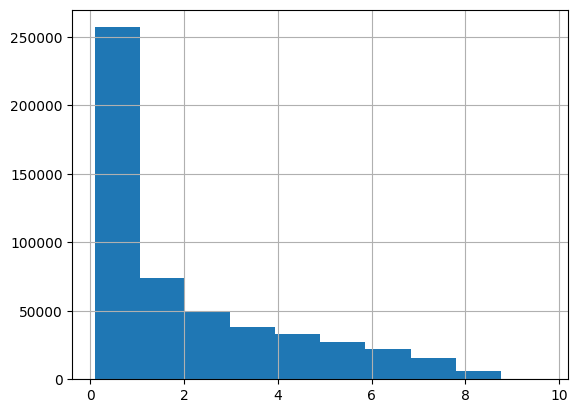

In [4]:
train = train[train["score"] > 0.1]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:06<00:00, 44.73it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7282


event   tolerance
onset   12           0.145613
        36           0.505906
        60           0.681127
        90           0.771721
        120          0.815541
        150          0.842021
        180          0.858943
        240          0.871527
        300          0.879972
        360          0.886724
wakeup  12           0.135316
        36           0.518560
        60           0.688424
        90           0.772104
        120          0.809610
        150          0.840176
        180          0.863651
        240          0.882026
        300          0.892610
        360          0.901919
dtype: float64